In this notebook we estimate the systematic error of the model.

It considers source free regions of all runs not in the galactic plane.

input: results from notebook 1
output: systematic error per model bin per energy (saved in folder '../fixed_material')

obs. here we work with 2 different units of systematic error: in units of 'standard deviation (std)' and in units of '% of bkg'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

from gammapy.data import DataStore

import warnings
warnings.filterwarnings('ignore')

In [2]:
# general options for the error estimation

# muoneff_flag is related if the user wants to calculate the error estimation for the bkg model with muoneff bins
# edisp is related to the energy threshold applied during the analysis

def call_analysis_type(analysis_type='alternative'):
    if analysis_type == 'standard':
        edisp, muoneff_flag = True, False # standard analysis
    else:
        edisp, muoneff_flag = False, True # increasing the statistics
    return edisp, muoneff_flag

In [3]:
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']
hesseras= ['hess1', 'hess2']
bdt_edges = cfg['bdt_edges']
model_str = cfg['model_str']
unit_list = ['deviation [std]', 'deviation [% of bkg]']
energy_bins = np.logspace(-1, 2, N_ebins+1)

if N_ebins==24:
    e_center= [0.1154782 ,  0.15399265,  0.2053525 ,  0.27384197,  0.36517413,
            0.48696753,  0.64938163,  0.86596432,  1.15478201,  1.53992656,
            2.05352501,  2.73841962,  3.65174137,  4.86967527,  6.49381614,
            8.65964312, 11.54781997, 15.3992658 , 20.53525094, 27.38419634,
           36.51741269, 48.6967522 , 64.93816094, 86.59643066]

In [94]:
# functions for plotting and saving 

def plot_mean_std(N_est, er_est, std_est):
    for unit in range(2): 
        fig, ax = plt.subplots(3, 7, figsize=(3*12,12))
        for zen in range(7):
            for model in range(3):
                N = N_est[zen, model]
                mean =er_est[zen, model, unit]
                std= std_est[zen, model, unit]
                ax[model][zen].plot(e_center, mean, label='mean')
                ax[model][zen].axhline(0, color='C0', alpha=0.5, ls=':', label='ideal mean')
                ax[model][zen].fill_between(e_center, mean-3/np.sqrt(N), mean+3/np.sqrt(N), color='lightyellow', label='statistical 3 sigma')
                ax[model][zen].plot(e_center, std, label='std')
                ax[model][zen].fill_between(e_center, std-3/np.sqrt(N), std+3/np.sqrt(N), color='lightyellow')
                ax[model][zen].axhline(1, color='C1', alpha=0.5, ls=':', label='ideal std')
                ax[model][zen].set_xscale('log')
                if unit ==0:
                    ax[model][zen].set_ylim(-7,7)
                else:
                    ax[model][zen].set_ylim(-20,20)

                ax[model][zen].legend()
                if model == 0:
                    ax[model][zen].set_title(f'zen={zen_bins[zen]}-{zen_bins[zen+1]}')
                if zen == 0:
                    ax[model][zen].set_ylabel(unit_list[unit])
                if model == 2:
                    ax[model][zen].set_xlabel(f'energy [TeV]')

        plt.show()
        
def plot_lookup_table(er_est):
    xv, yv = np.meshgrid(zen_bins, energy_bins, indexing='ij')
    fig, ax = plt.subplots(2, 1, dpi=120, figsize=(4,7))
    
    for i in range(2):
        Z = np.zeros((len(zen_bins),len(energy_bins)))
        for zen in range(len(zen_bins)-1):
            for e in range(len(energy_bins)-1):
                Z[zen][e] = er_est[zen, 2, i, e]

        c = ax[i].pcolor(yv, xv, Z, cmap='plasma')
        fig.colorbar(c, ax=ax[i], label=unit_list[i])
        for zen in zen_bins:
            ax[i].axhline(zen, color='lightgray')
        for e in energy_bins:
            ax[i].axvline(e, color='lightgray')


        ax[i].set_xscale('log')
        ax[i].set_xlabel('Energy [TeV]')
        ax[i].set_ylabel('zenith')
    plt.show()
        
def saving_model(hessera, er_est, edisp, muoneff_flag):
    if muoneff_flag==False:
        model=2
        np.savetxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}.txt', er_est[:, model, 0, :])
        np.savetxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}_bkgpercentage.txt', er_est[:, model, 1, :])    
    else:
        for model in range(3):
            np.savetxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}.txt', er_est[:, model, 0, :])
            np.savetxt(f'../fixed_material/edisp{edisp}_muoneff{muoneff_flag}_{hessera}_error_estimation_{model_str[model]}_bkgpercentage.txt', er_est[:, model, 1, :])    

In [8]:
# functions for estimating the result

def get_results(hessera, edisp, muoneff_flag):
    
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    table = ds.obs_table
    
    # load results
    if hessera == 'hess1':
        idx_max = 37
    elif hessera == 'hess2':
        idx_max = 7
    for idx in range(idx_max):
        if edisp==True and muoneff_flag==False:
            file_path = f'results/dataspectrum_edisp_NOmuoneff'
        elif edisp==True and muoneff_flag==True:
            file_path = f'results/dataspectrum_edisp_muoneff'
        elif edisp==False and muoneff_flag==True:
            file_path = f'results/dataspectrum_muoneff'            
        
        if idx==0:
            file = np.loadtxt(f'{file_path}_{hessera}_part{idx}.txt')
        else:
            file = np.concatenate((file, np.loadtxt(f'{file_path}_{hessera}_part{idx}.txt')))
    obsid_list = file[:, 0].astype(int)
    obsid_list_original = np.loadtxt(f'initial_runlist_{hessera}.txt').astype(int)
    print(f'there are {len(obsid_list_original)-len(obsid_list)}/{len(obsid_list_original)} with problems')

    # getting the error per run in units of statistical standard deviation and in units of bkg percentage
    counts=file[:, 1:N_ebins+1]
    background = file[:, N_ebins+1:]
    error_std = (counts - background)/np.sqrt(background)
    error_percentage = 100*(counts - background)/background

    #getting information of zenith and model of each run (these are the bins for error estimation)
    info = []
    for obs in obsid_list:
        idx = np.where(table['OBS_ID']==obs)[0][0]
        zen_pnt = table['ZEN_PNT'][idx]
        zen_bin = np.sum(zen_pnt > zen_bins) - 1

        if muoneff_flag==True:
#        if 1==1:
            muoneff = table['MUONEFF'][idx]
            if muoneff > 0.085:
                model = 0 #'B'
            elif muoneff >= 0.075:
                    model = 1 # 'D'
            else:
                model = 2 #'C'
        else:
            model=2

        info.append([obs, zen_pnt, zen_bin, model])
    info= np.asarray(info)

    return info, error_std, error_percentage
    
def calculate_error(info, error_std, error_percentage):
    
    def plot(res, model, zen, ax_idx):
        ax[ax_idx][zen].plot(e_center, res.T, color='lightgray');
        ax[ax_idx][zen].plot(e_center, (res)[0], color='lightgray', label='1 run');
        ax[ax_idx][zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'mean over\nN_runs={np.sum(mask)}');
        ax[ax_idx][zen].set_xscale('log')
        ax[ax_idx][zen].legend(loc='lower right')
        if ax_idx < 3:
            ax[ax_idx][zen].set_ylim(-10,10)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [std]')
        else:
            ax[ax_idx][zen].set_ylim(-50,50)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [bkg %]')
            

    # 7 corresponds to zen bins, 3 to 
    N_est = np.ndarray((7, 3, 1), dtype=int)
    er_est = np.ndarray((7, 3, 2, 24)) #error for 7 zenbins, 3 bkg models, 2 units of error std and percentage, 24 energy bins 
    std_est = np.ndarray((7, 3, 2, 24)) # here is the std of the error
    
    fig, ax = plt.subplots(6, 7, figsize=(3*12,24))
    for zen in range(7):
        for model in range(3):
            mask_zen = info.T[2] == zen
            mask_model = info.T[3] == model
            mask = mask_zen & mask_model
            N_est[zen][model][0] = np.sum(mask)
            
            if np.sum(mask) == 0:
                print(f'no runs for zen={zen}, model={model_str[model]}')
            else: 
                mean_value = np.nanmean(error_std[mask].T, axis=1)
                mean_value = [mean_value[ii] if abs(mean_value[ii]) > 5/np.sqrt(np.sum(mask)) else 0 for ii in range(N_ebins)]
                mean_value_per = np.nanmean(error_percentage[mask].T, axis=1)
                mean_value_per = [mean_value_per[ii] if abs(mean_value[ii]) > 5/np.sqrt(np.sum(mask)) else 0 for ii in range(N_ebins)]
                
                er_est[zen][model][0] = mean_value
                er_est[zen][model][1] = mean_value_per
                std_est[zen][model][0] = np.nanstd(error_std[mask].T, axis=1)
                std_est[zen][model][1] = np.nanstd(error_percentage[mask].T, axis=1)
                
                plot(error_std[mask], model, zen, model)
                plot(error_percentage[mask], model, zen, model+3)

                er_est[zen][model][0] = np.nanmean(error_std[mask].T, axis=1)
                er_est[zen][model][1] = np.nanmean(error_percentage[mask].T, axis=1)
                std_est[zen][model][0] = np.nanstd(error_std[mask].T, axis=1)
                std_est[zen][model][1] = np.nanstd(error_percentage[mask].T, axis=1)
                
                plot(error_std[mask], model, zen, model)
                plot(error_percentage[mask], model, zen, model+3)
                
    #########################################
    ## setting some features of the systematic errors by hand:
    
    ## setting the systematic for the zen 0-15, model B, from energy bin 15, to 0 because there the model construction does not have enough statistics and therefore the systematic estimation is wrong
    ## the motivation to 0 is because there is no enough statistics, and therefore setting to 0 is good
    er_est[0,0,:, 15:]=0

    # i also set to above 30 TeV systematic to 0
    # due to the lack of statistics in the model construction (not the lack of runs, but the lack of data in these runs)
    for zen in range(7):
        for model in range(3):
            er_est[zen,model,:, 20:]=0
            
    return N_est, er_est, std_est

### description of the plots

** all plots are shown with units of std and % of bkg.
The first one is used to define where to assume systematic error and the second unit is used for estimating it into a dataset

- the first plots shows all the runs in gray and the mean in black. From this we can see how it is scatter for each energy for each model bin
- the second set of plots shows the clean up systematic error. Considering that the mean can also carry fluctuation due to statistics, we assume the systematic error is only present when the deviation is > 5/sqrt(numbr of runs), it means, we consider 5 sigma of statistical fluctuations, if the mean is above it, then it is systematic error.

# HESS1

there are 0/7260 with problems
no runs for zen=0, model=B
no runs for zen=0, model=D
no runs for zen=1, model=B
no runs for zen=1, model=D
no runs for zen=2, model=B
no runs for zen=2, model=D
no runs for zen=3, model=B
no runs for zen=3, model=D
no runs for zen=4, model=B
no runs for zen=4, model=D
no runs for zen=5, model=B
no runs for zen=5, model=D
no runs for zen=6, model=B
no runs for zen=6, model=D


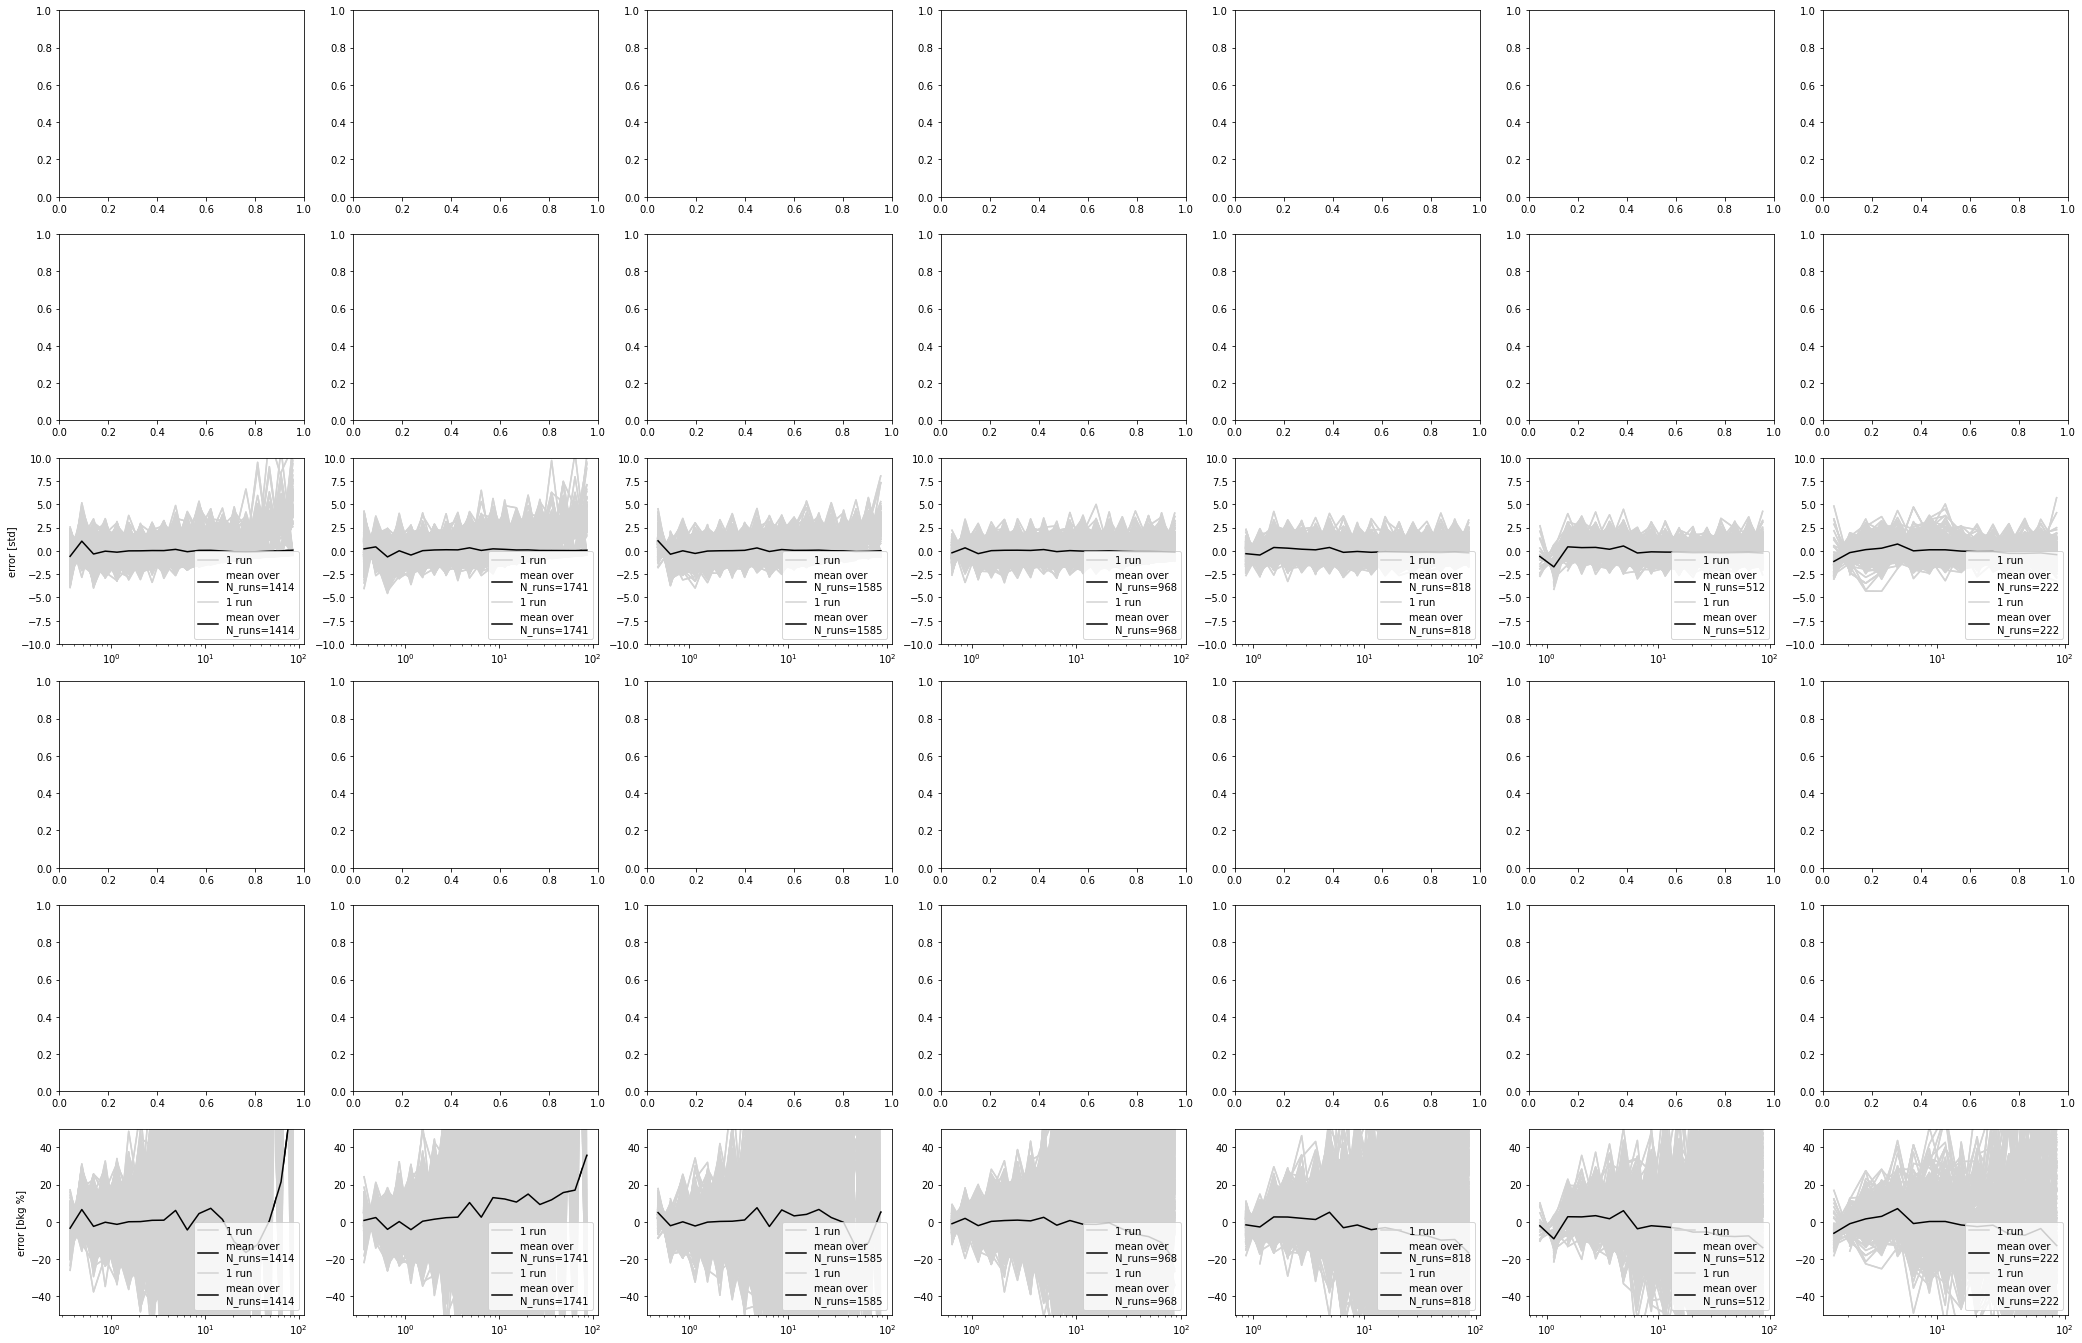

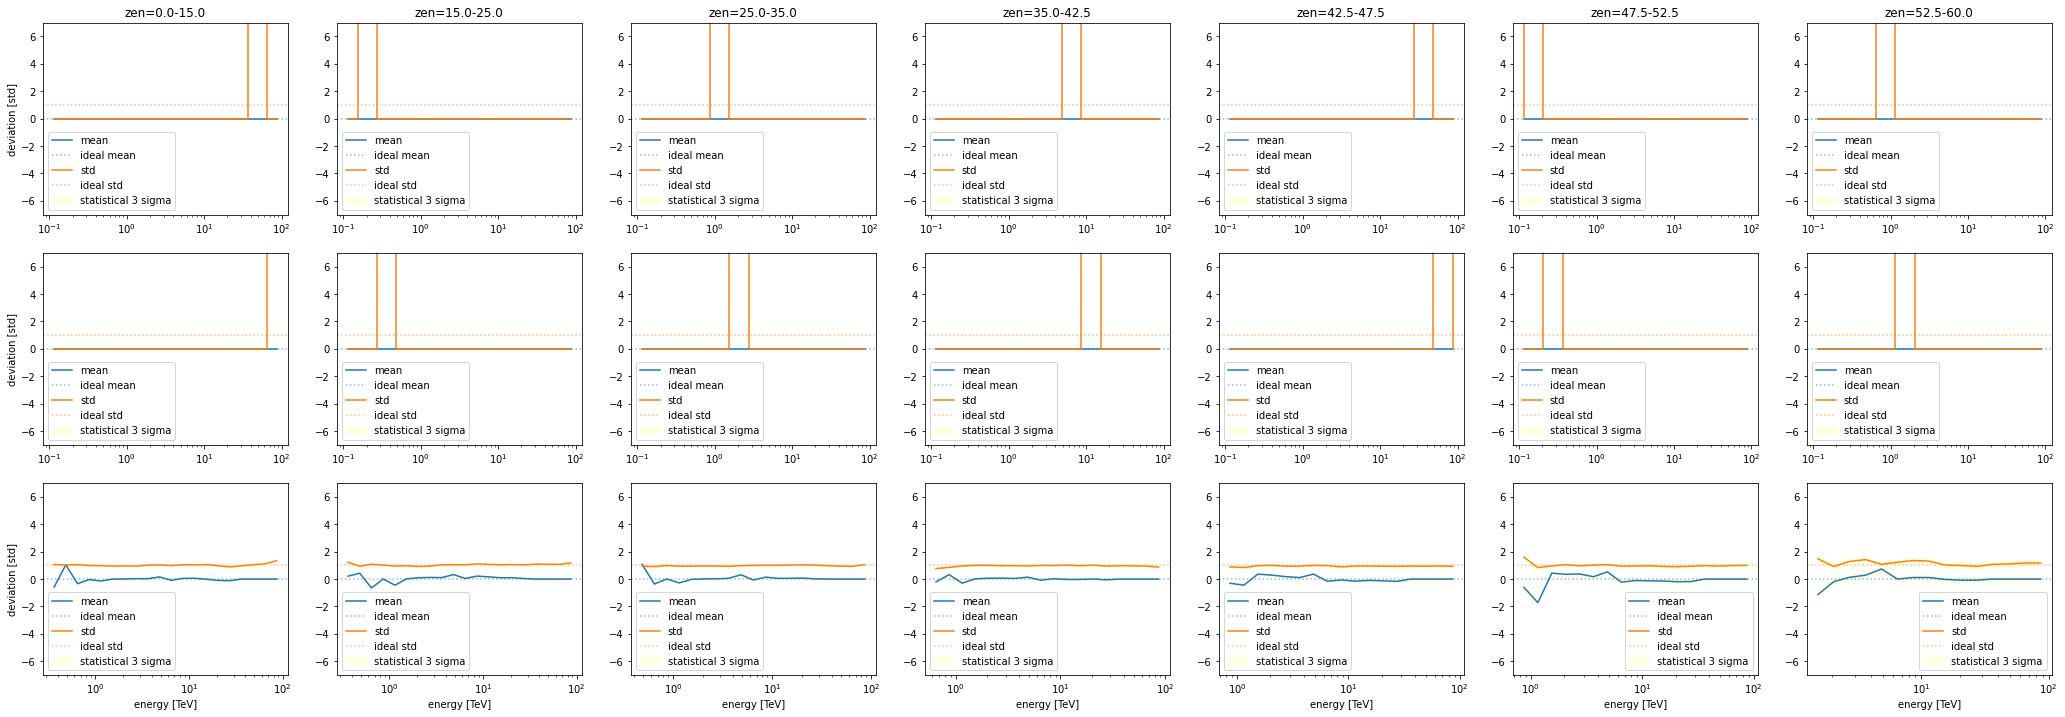

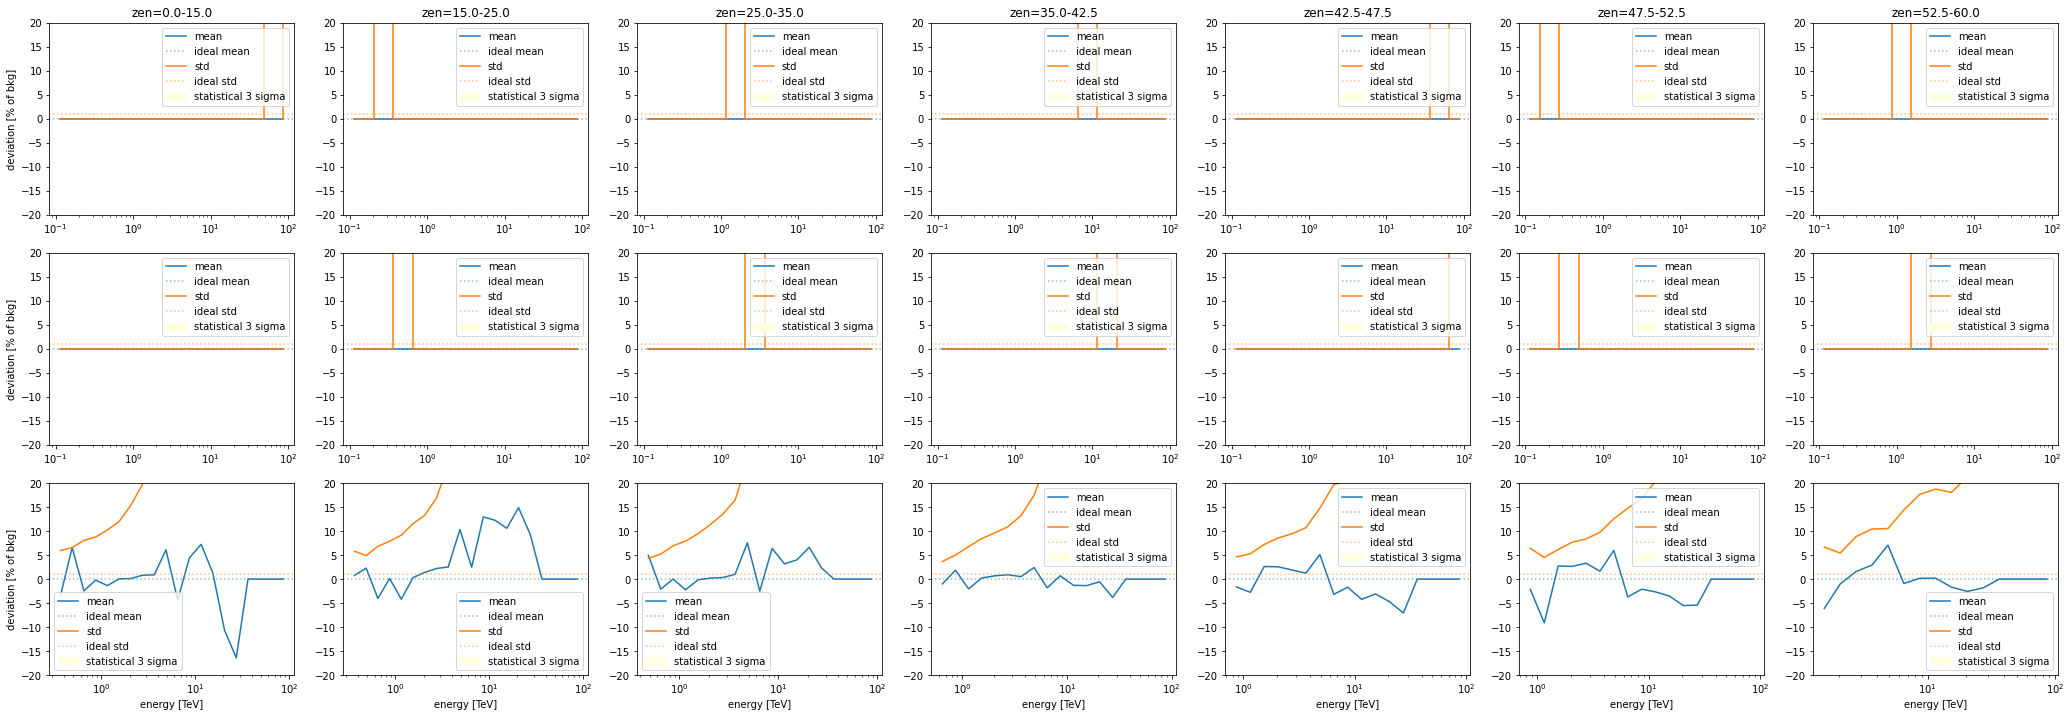

In [9]:
hessera = 'hess1'

edisp, muoneff_flag = call_analysis_type('standard')
info, error_std, error_percentage = get_results(hessera, edisp, muoneff_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
plot_mean_std(N_est, er_est, std_est)
saving_model(hessera, er_est, edisp, muoneff_flag)

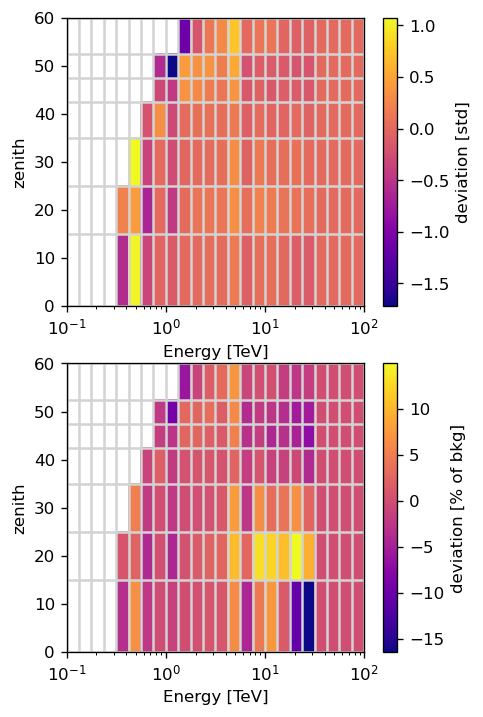

In [95]:
plot_lookup_table(er_est)

there are 1/7260 with problems


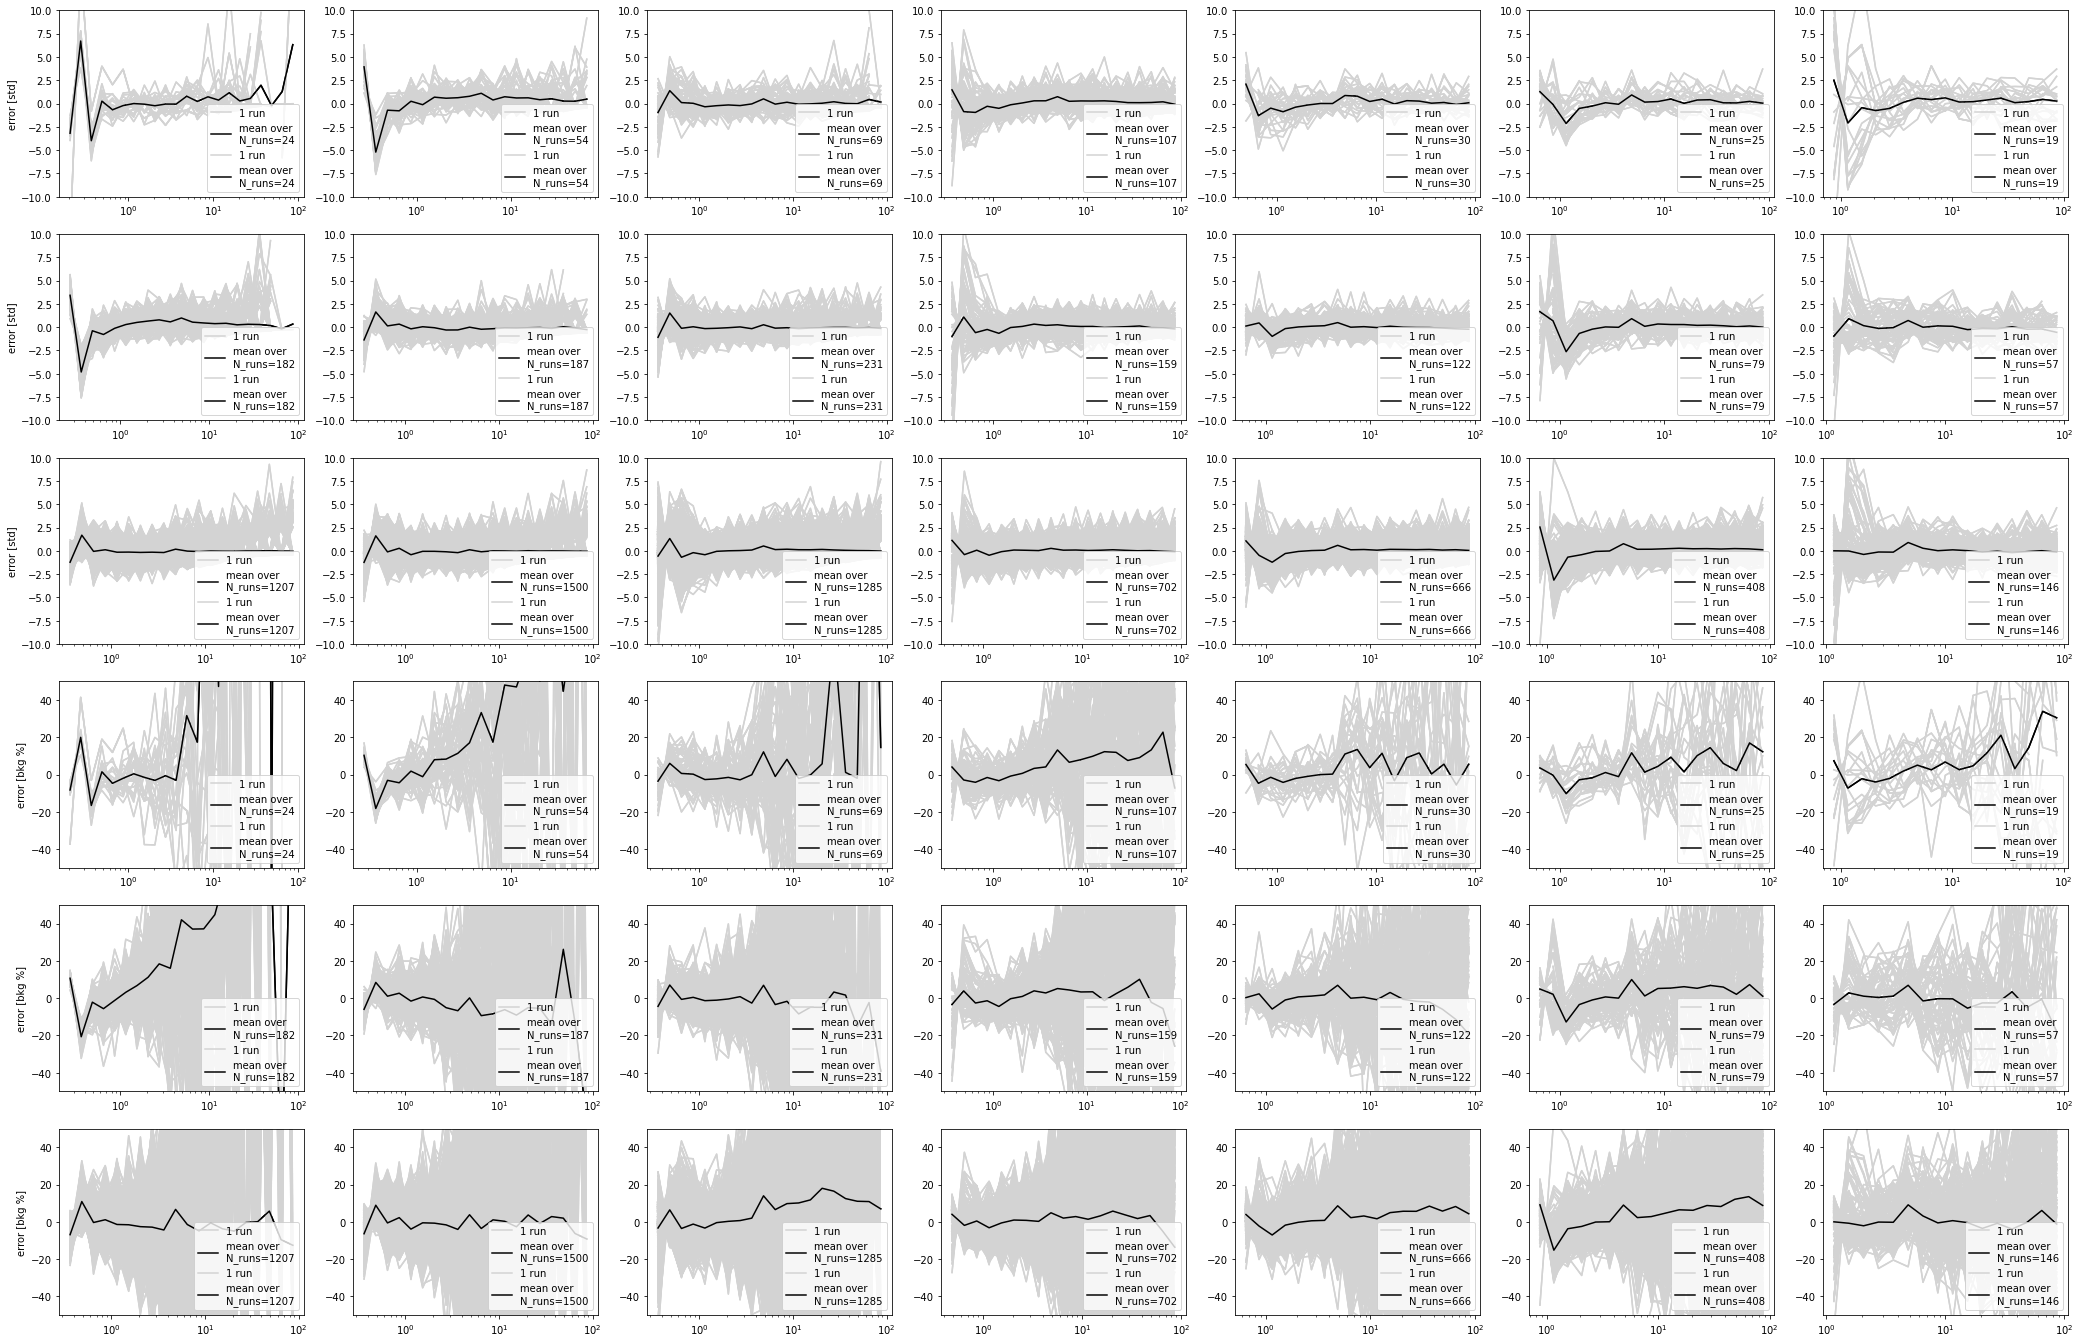

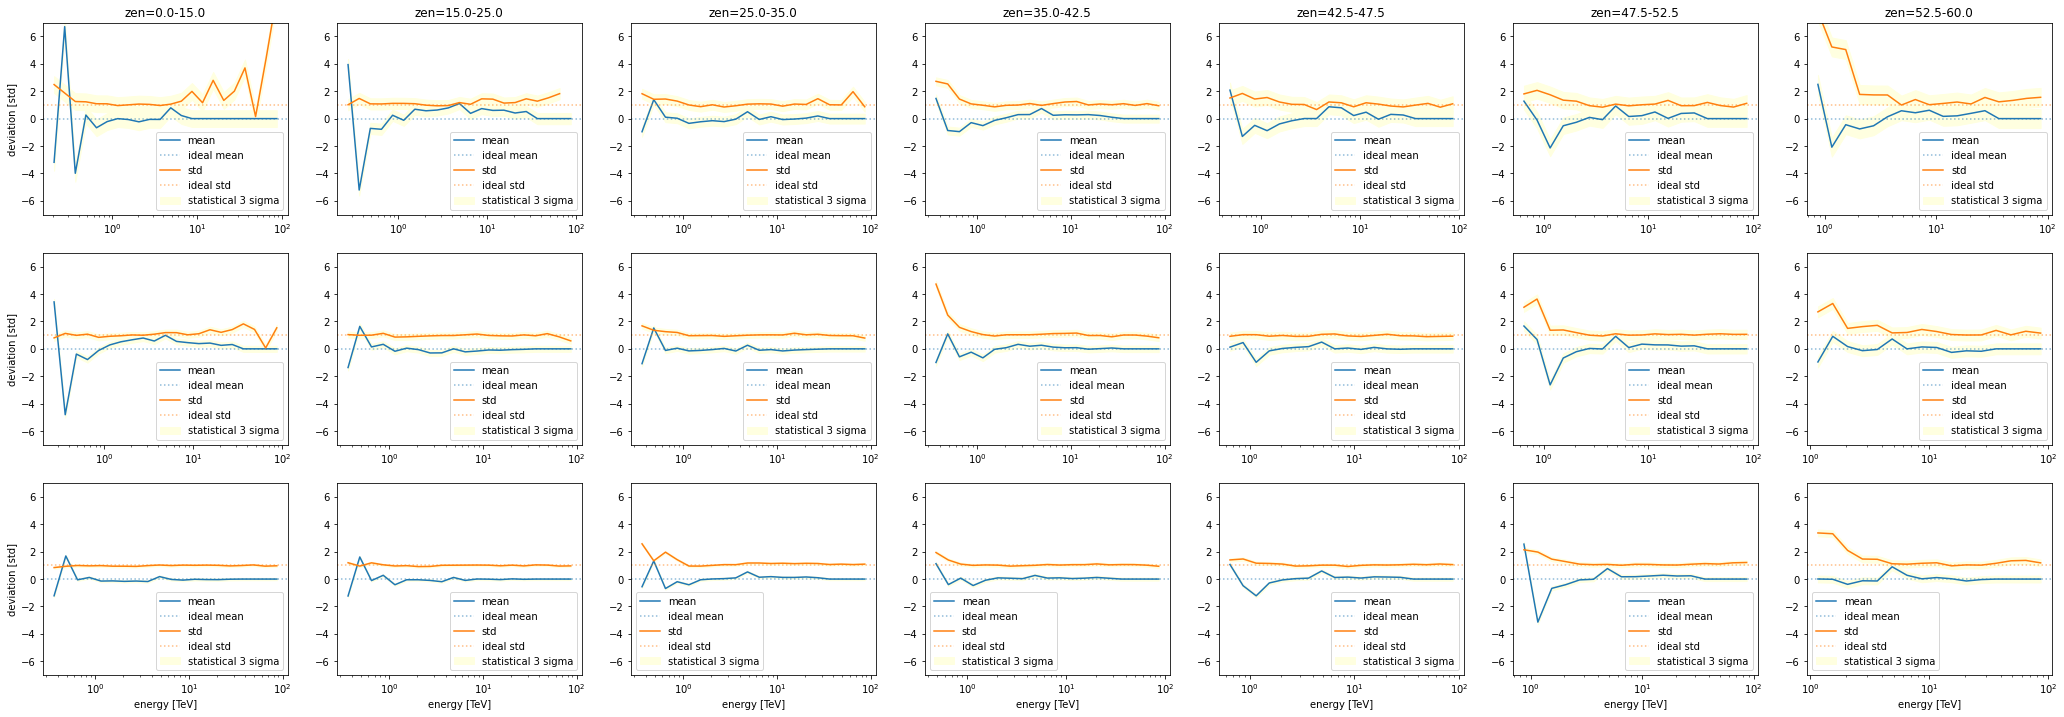

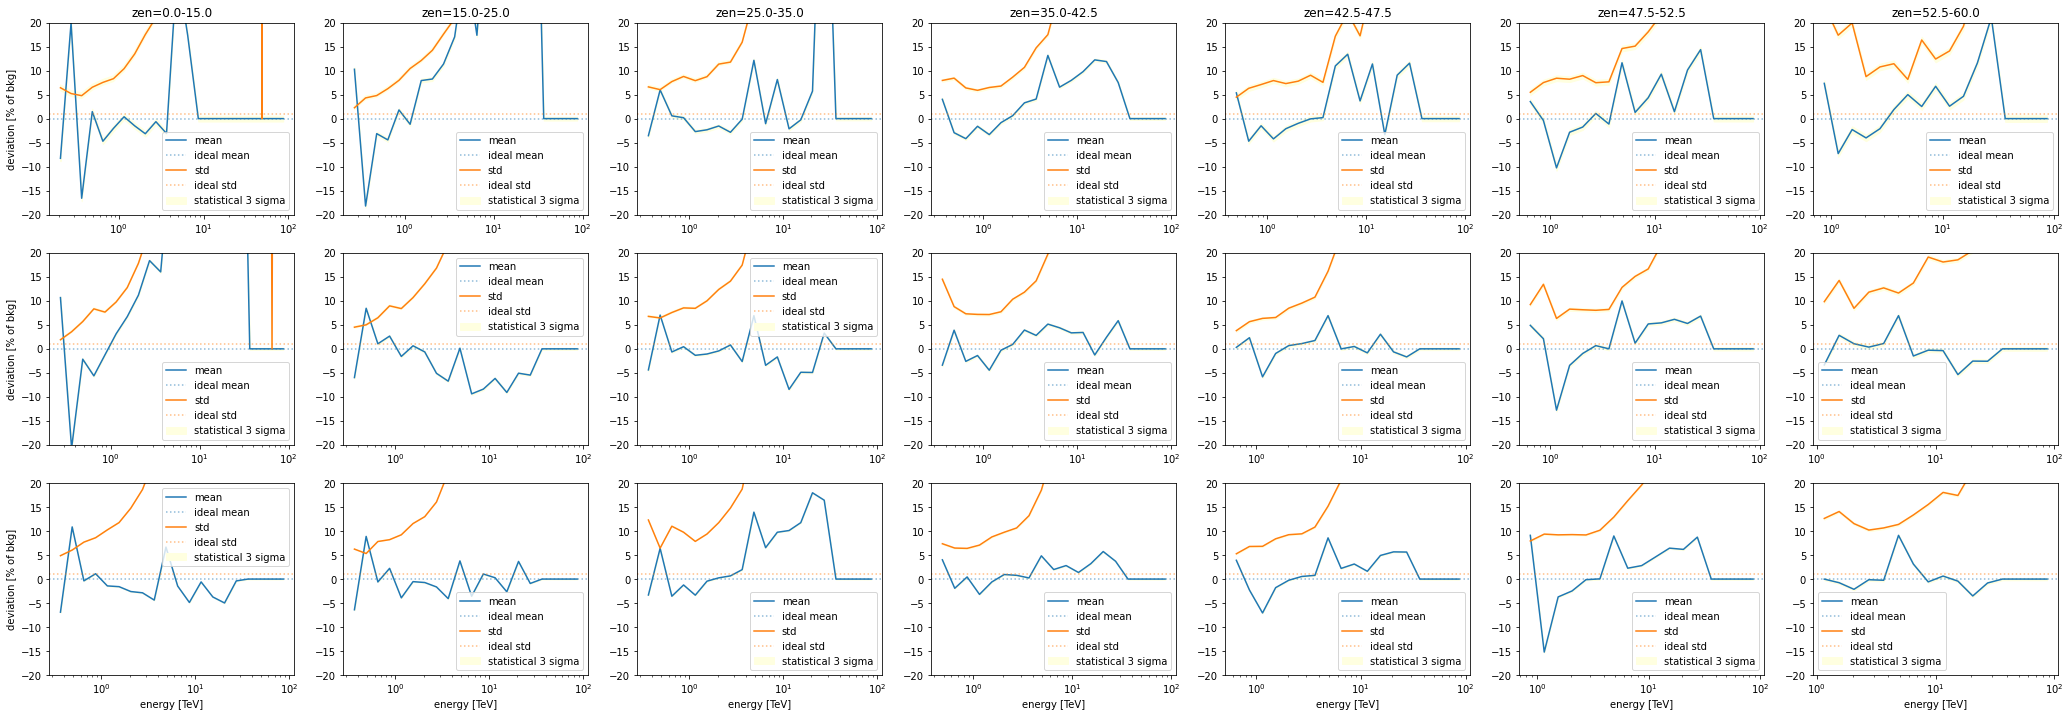

In [7]:
hessera = 'hess1'

edisp, muoneff_flag = call_analysis_type('alternative')
info, error_std, error_percentage = get_results(hessera, edisp, muoneff_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
plot_mean_std(N_est, er_est, std_est)
saving_model(hessera, er_est, edisp, muoneff_flag)

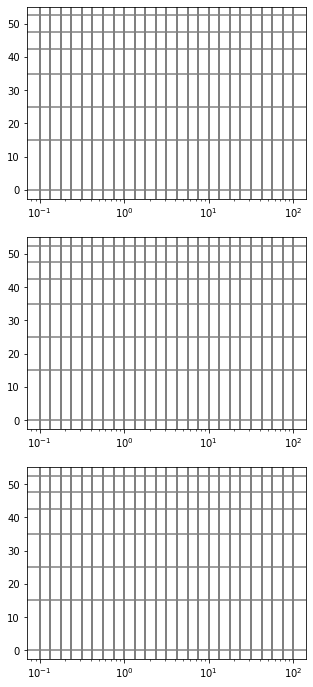

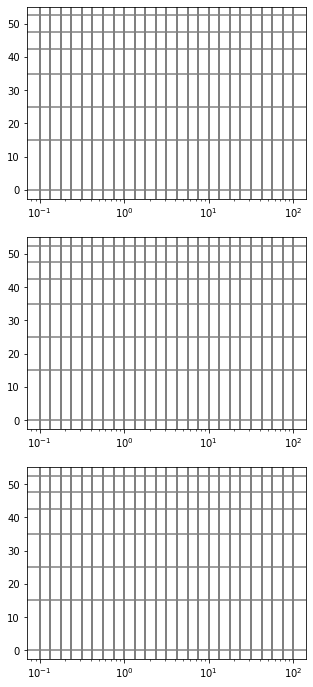

In [19]:
for unit in range(2): 
    fig, ax = plt.subplots(3, 1, figsize=(5,12))
    for model in range(3):
        for zen in range(7):
            for e in energy_bins:
                ax[model].axvline(e, color='gray')
            ax[model].axhline(zen_bins[zen], color='gray')
        ax[model].set_xscale('log')

# HESS2

there are 0/1235 with problems
no runs for zen=0, model=B
no runs for zen=0, model=D
no runs for zen=1, model=B
no runs for zen=1, model=D
no runs for zen=2, model=B
no runs for zen=2, model=D
no runs for zen=3, model=B
no runs for zen=3, model=D
no runs for zen=4, model=B
no runs for zen=4, model=D
no runs for zen=5, model=B
no runs for zen=5, model=D
no runs for zen=6, model=B
no runs for zen=6, model=D


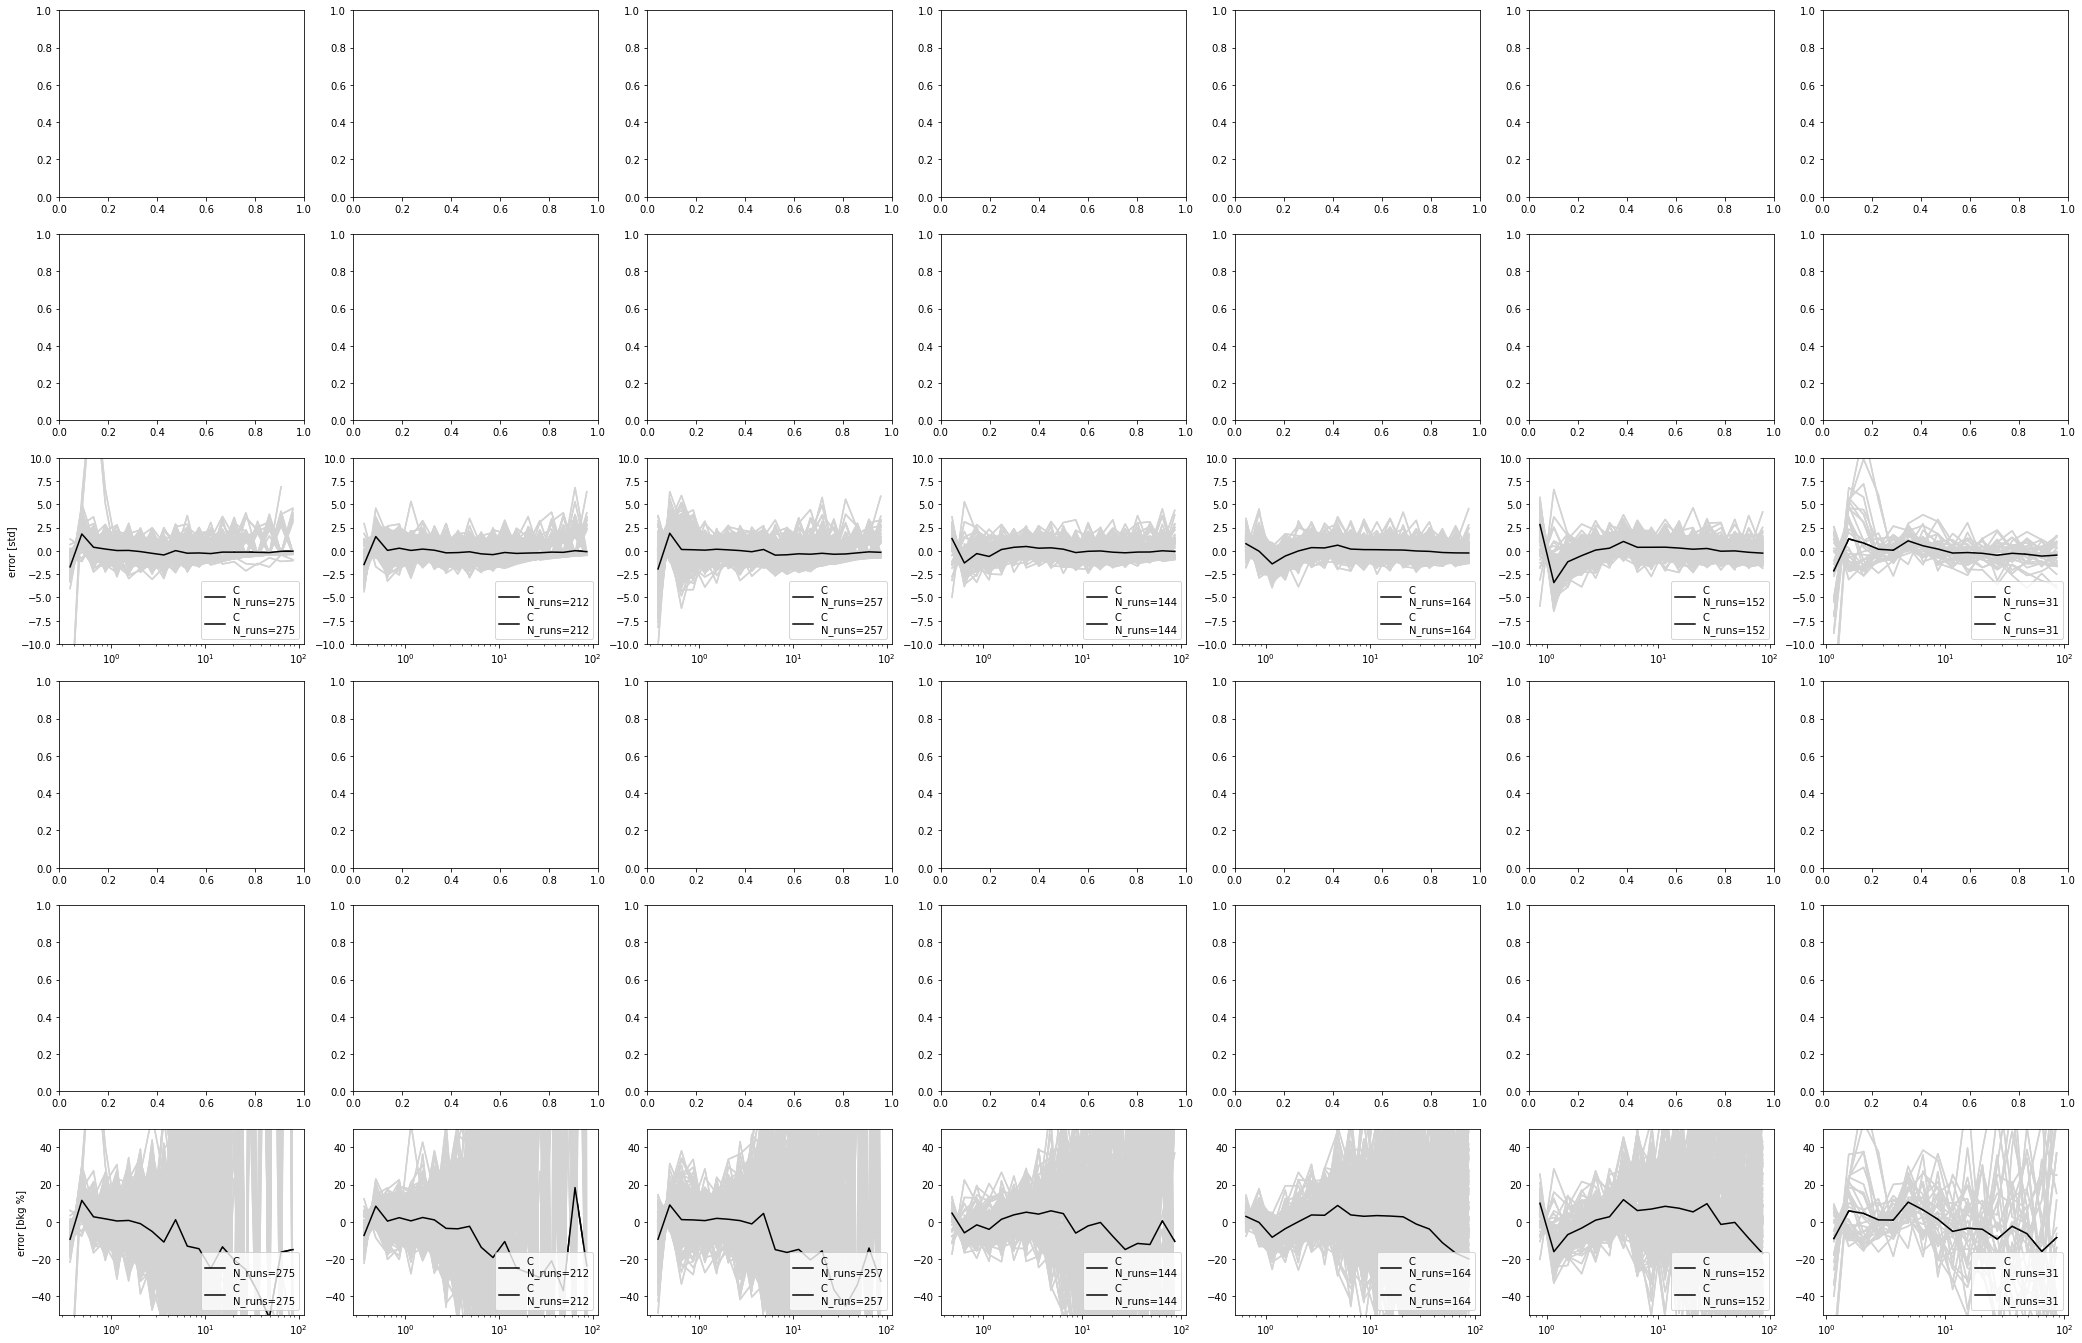

In [9]:
hessera= 'hess2'
info, error_std, error_percentage = get_results(hessera)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)

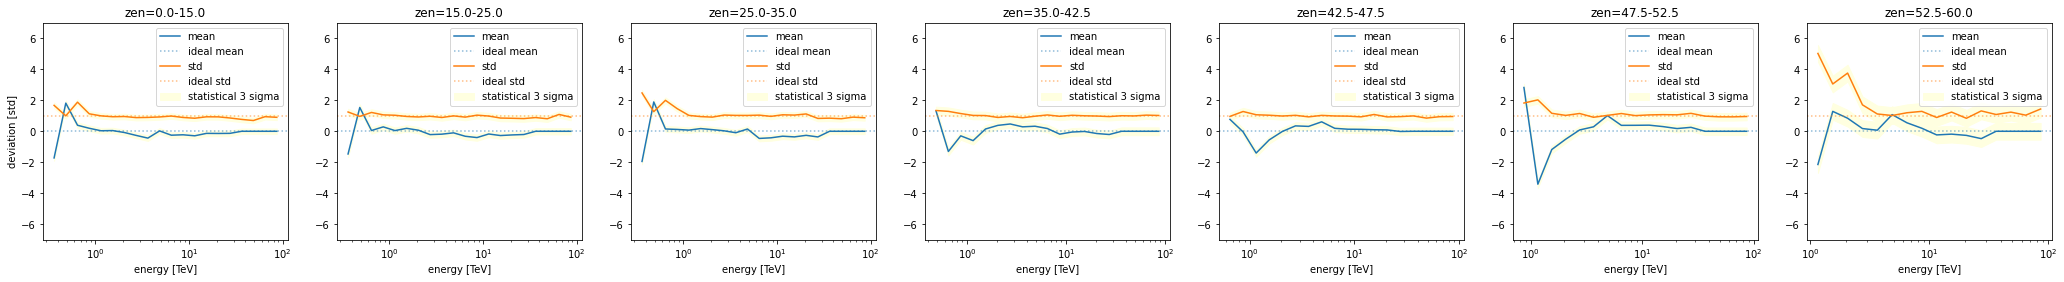

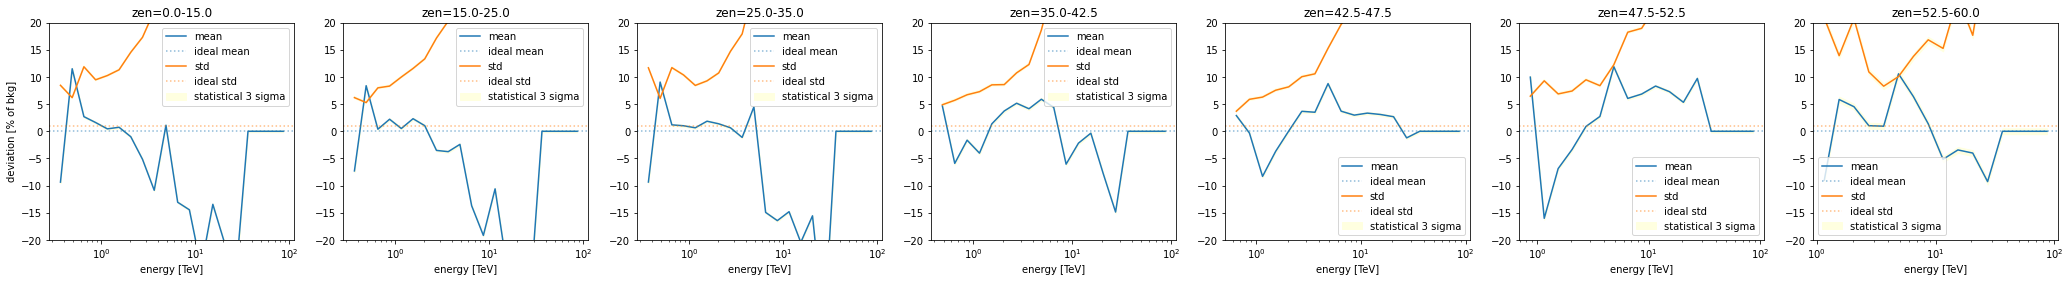

In [10]:
for unit in range(2): 
    fig, ax = plt.subplots(1, 7, figsize=(3*12,4))
    for zen in range(7):
        for model in range(2, 3):
            N = N_est[zen, model]
            mean =er_est[zen, model, unit]
            std= std_est[zen, model, unit]
            ax[zen].plot(e_center, mean, label='mean')
            ax[zen].axhline(0, color='C0', alpha=0.5, ls=':', label='ideal mean')
            ax[zen].fill_between(e_center, mean-3/np.sqrt(N), mean+3/np.sqrt(N), color='lightyellow', label='statistical 3 sigma')
            ax[zen].plot(e_center, std, label='std')
            ax[zen].fill_between(e_center, std-3/np.sqrt(N), std+3/np.sqrt(N), color='lightyellow')
            ax[zen].axhline(1, color='C1', alpha=0.5, ls=':', label='ideal std')
            ax[zen].set_xscale('log')
            if unit ==0:
                ax[zen].set_ylim(-7,7)
            else:
                ax[zen].set_ylim(-20,20)
            ax[zen].legend()
            ax[zen].set_title(f'zen={zen_bins[zen]}-{zen_bins[zen+1]}')
            ax[zen].set_xlabel(f'energy [TeV]')
                
            if zen == 0:
                ax[zen].set_ylabel(unit_list[unit])

    plt.show()

In [11]:
for model in range(2,3):
    np.savetxt(f'../fixed_material/{hessera}_error_estimation_{model_str[model]}.txt', er_est[:, model, 0, :])
    np.savetxt(f'../fixed_material/{hessera}_error_estimation_{model_str[model]}_bkgpercentage.txt', er_est[:, model, 1, :])    

# END OF THE SYSTEMATIC ERROR ESTIMATION

These plots above are the systematic error per model bin per energy. This is what it is the input necessary for applying it into the dataset.

There are some features that would be interesing to understand. And this is dedicated in the next section:

### further studies about the systematic error

Correlation of the first and second energy bin:

From the clean plot, which shows the mean in blue curve, apparently there is a correlation, the first and the second energy

there are 1/7260 with problems


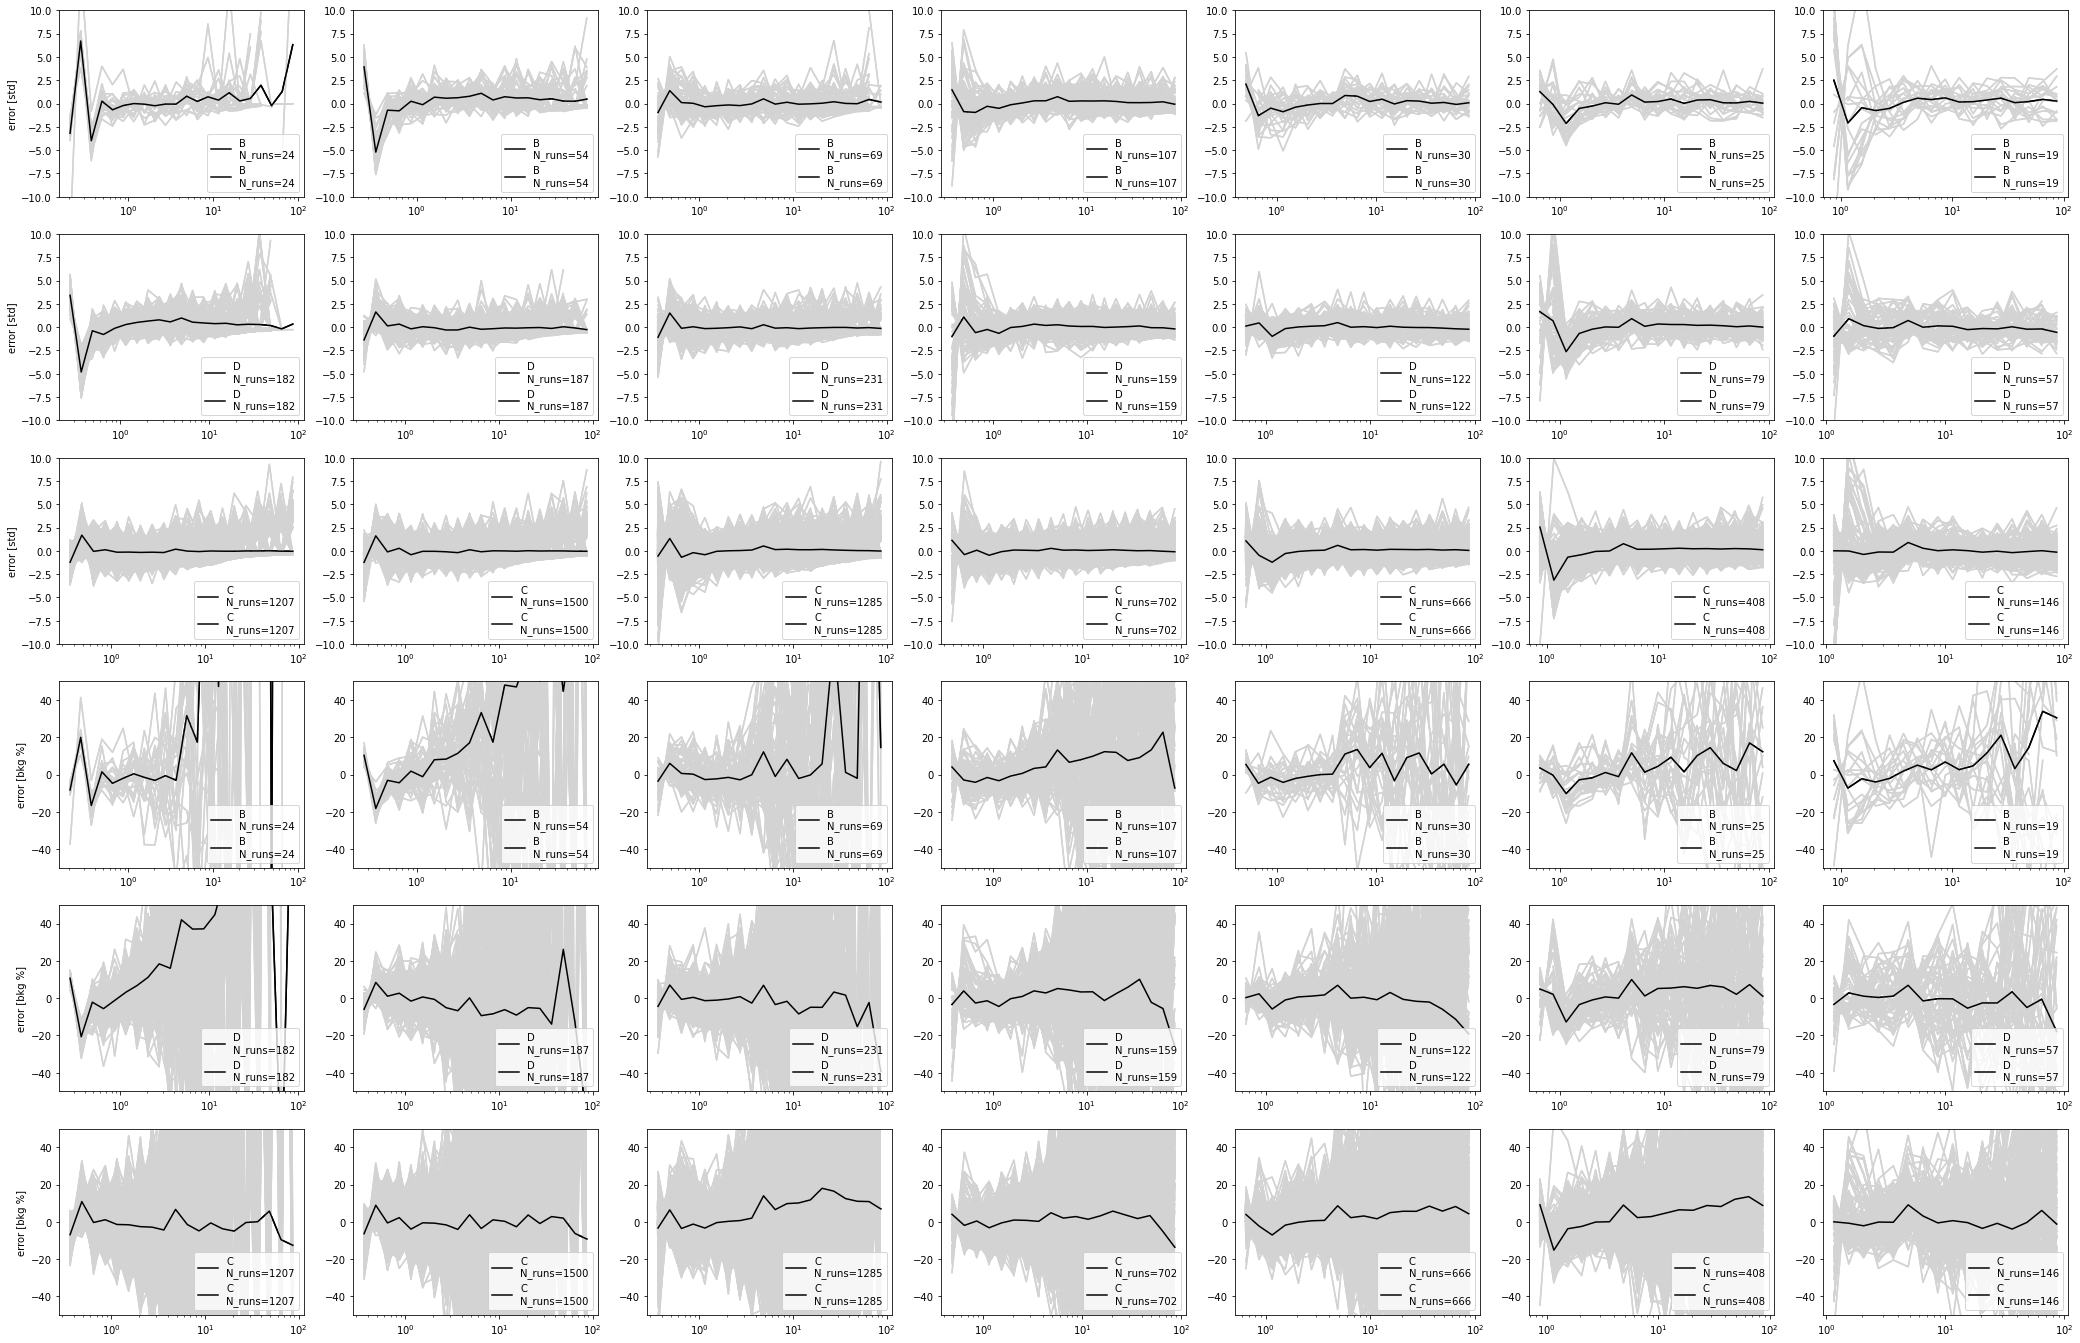

In [15]:
hessera = 'hess1'
info, error_std, error_percentage = get_results(hessera, edisp=False)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)

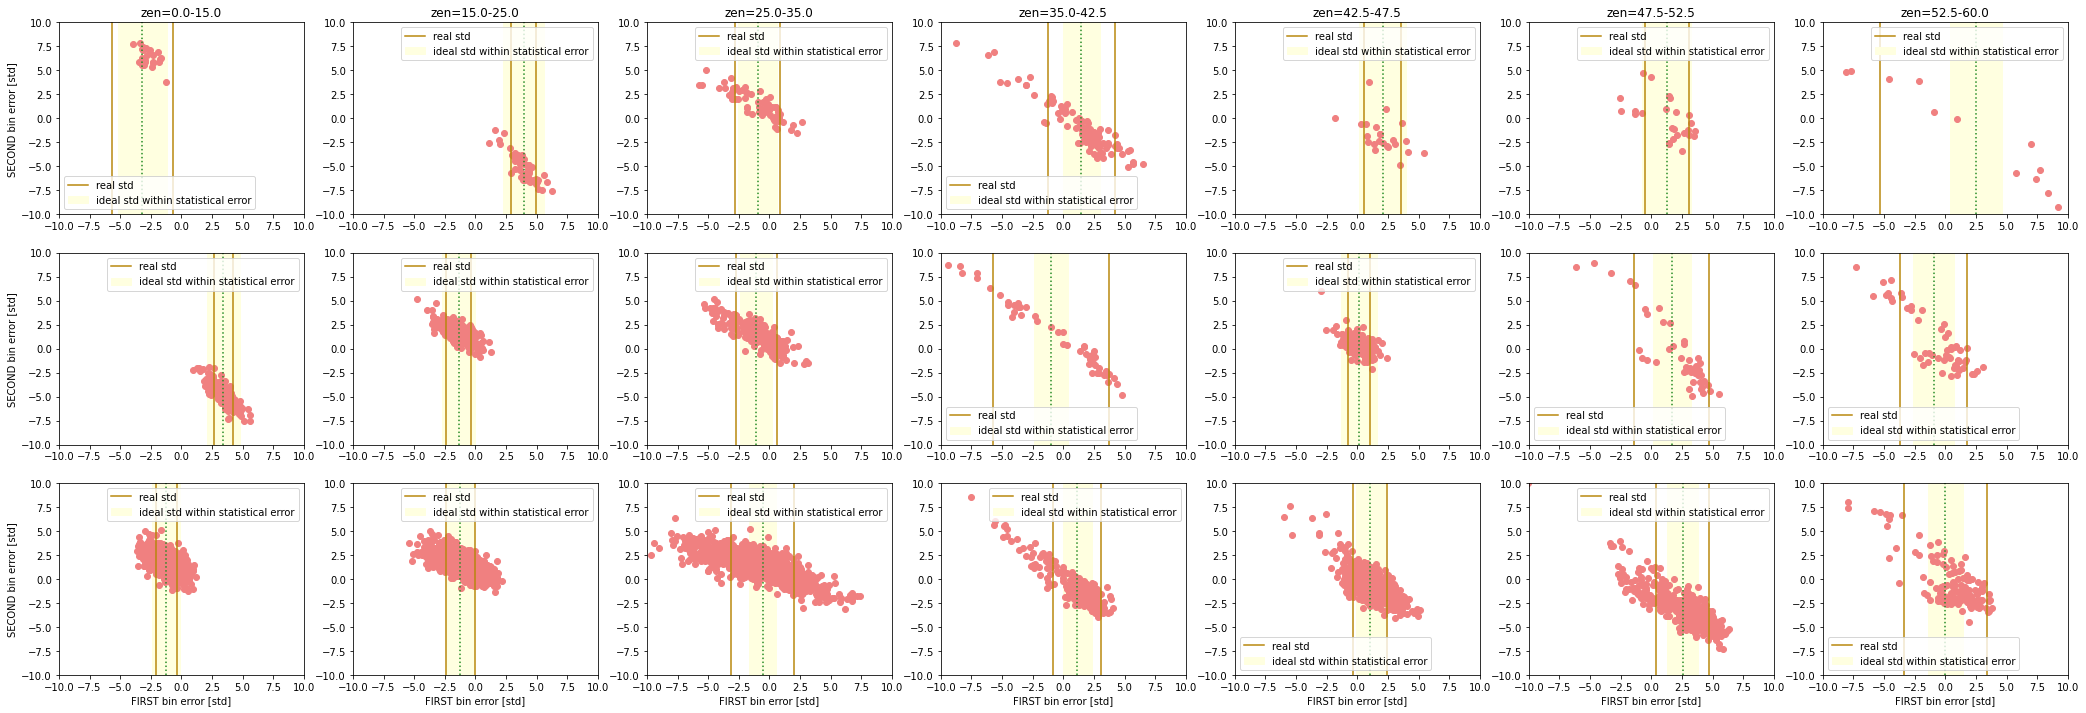

In [16]:
lim_std = 5
fig, ax = plt.subplots(3, 7, figsize=(3*12,12))
for zen in range(7):
    for model in range(3):
        
        mask = (info[:, 2] == zen) & (info[:, 3] == model)
        data = error_std[mask]
        
        color='lightcoral'

        first_bin_flag = True
        for i in range(24):
            if first_bin_flag:
                if np.sum(np.isnan(data.T[i])) != np.sum(mask):
                    mean= np.nanmean(data[:, i])
                    std = np.nanstd(data[:, i])
                    ax[model][zen].fill_between(x=[mean-1-lim_std/np.sqrt(np.sum(mask)), mean+1+lim_std/np.sqrt(np.sum(mask))], y1=-10, y2=10, color='lightyellow', label='ideal std within statistical error')
                    ax[model][zen].scatter(data[:, i], data[:, i+1], color=color)
                    ax[model][zen].axvline(mean, ls=':', color='forestgreen')
                    ax[model][zen].axvline(mean-std, color='darkgoldenrod', label='real std')
                    ax[model][zen].axvline(mean+std, color='darkgoldenrod')
                    ax[model][zen].legend()
                    ax[model][zen].set_ylim(-10,10)
                    ax[model][zen].set_xlim(-10,10)
                    
                    first_bin_flag = False     
        if model == 0:
            ax[model][zen].set_title(f'zen={zen_bins[zen]}-{zen_bins[zen+1]}')
        if zen == 0:
            ax[model][zen].set_ylabel(f'SECOND bin error [std]')
        if model == 2:
            ax[model][zen].set_xlabel(f'FIRST bin error [std]')

                
plt.show()

From these plots we can see that the first and the second energy bin (x and y axis respectively) are correlated.
Each datapoint is related to 1 run.

After that I want to understand what is the parameter that caused this discrepancy, and I suspect it is related to the zen_pnt of the run.

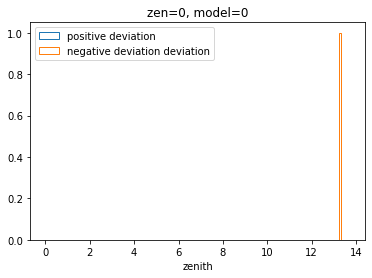

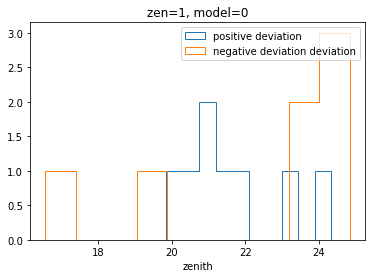

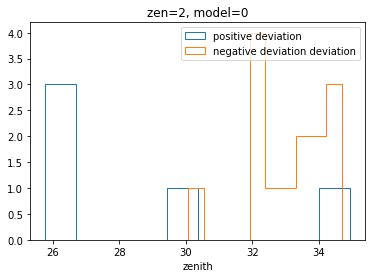

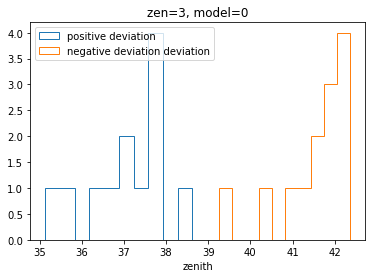

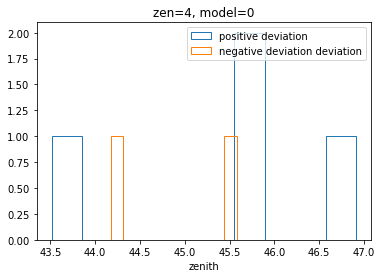

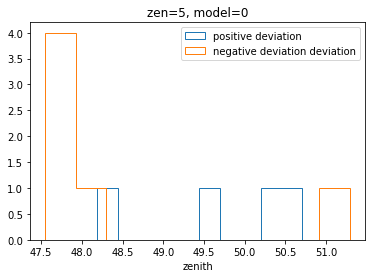

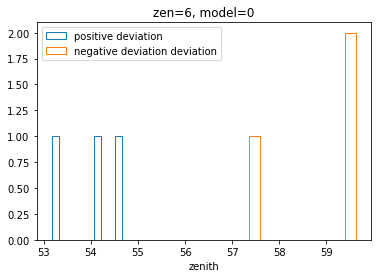

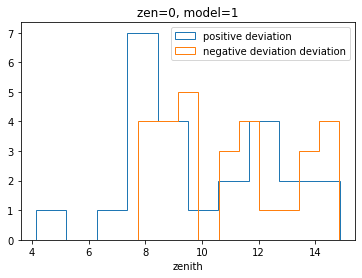

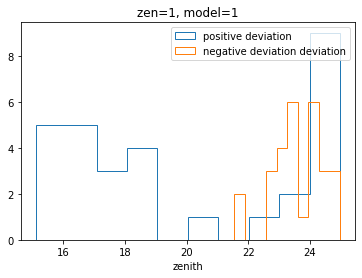

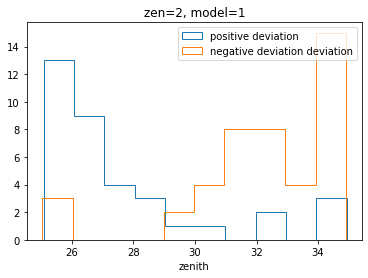

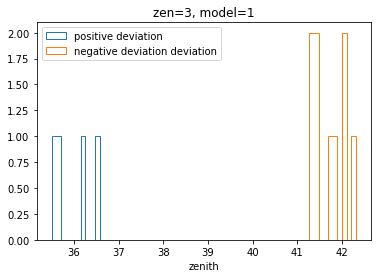

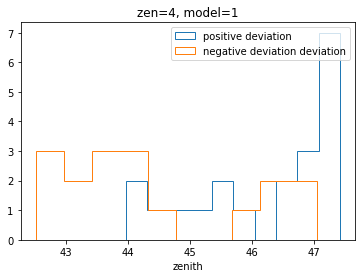

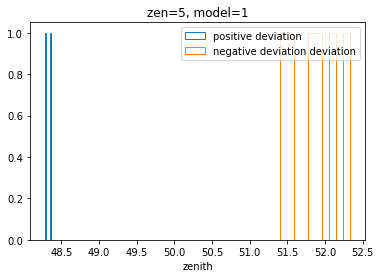

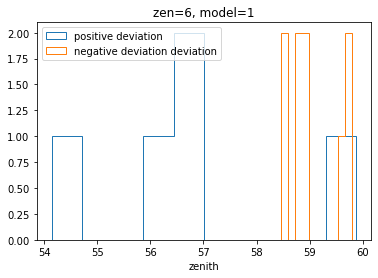

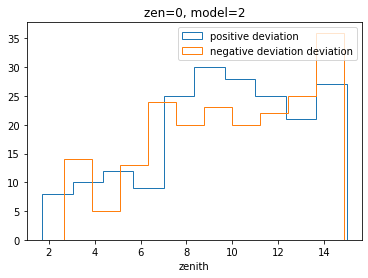

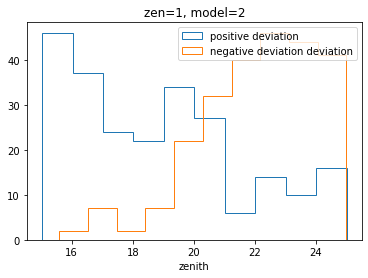

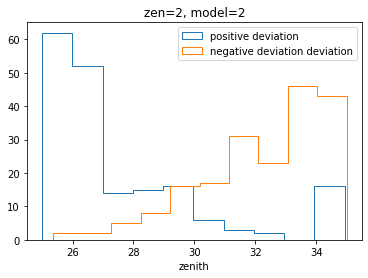

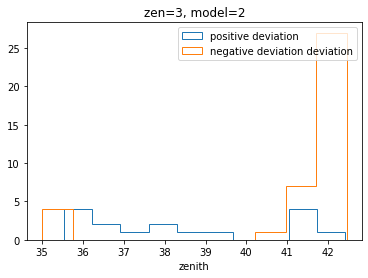

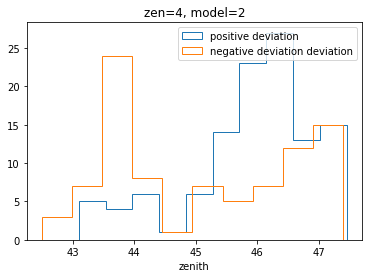

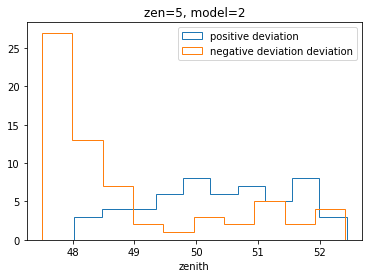

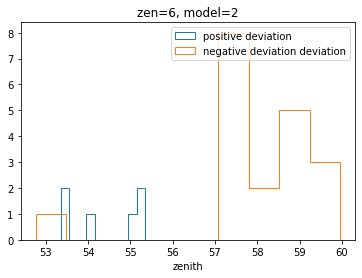

In [19]:
# taking the example of zen=2 and model=2
for model in range(3):
    for zen in range(7):
        mask = (info[:, 2] == zen) & (info[:, 3] == model)
        data = error_std[mask]

        first_bin_flag = True
        for i in range(24):
            if first_bin_flag:
                if np.sum(np.isnan(data.T[i])) != np.sum(mask):
                    first_bin_flag = False     
                    mean= np.nanmean(data[:, i])
                    std = np.nanstd(data[:, i])

                    mask_bin1 = data.T[i] > mean+ std
                    runlist_1 = list((info[mask][mask_bin1]).T[0].astype(int))
                    plt.hist((info[mask][mask_bin1]).T[1], histtype='step', label='positive deviation')

                    mask_bin1 = data.T[i] < mean-std
                    runlist_2 = list((info[mask][mask_bin1]).T[0].astype(int))
                    plt.hist((info[mask][mask_bin1]).T[1], histtype='step', label='negative deviation deviation')
                    plt.legend()
                    plt.xlabel('zenith')
                    plt.title(f'zen={zen}, model={model}')
                    plt.show()

